<a href="https://colab.research.google.com/github/MarielaNina/-Guide-to-Advanced-LLM-Techniques-Public/blob/main/M%C3%B3dulo_2_A_Arte_e_a_Ci%C3%AAncia_da_Engenharia_de_Prompt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulo 2: A Arte e a Ciência da Engenharia de Prompt

# Introdução

Nos últimos anos, os Modelos de Linguagem de Grande Porte (LLMs) revolucionaram o processamento de linguagem natural. Um marco importante foi a descoberta de que modelos com bilhões de parâmetros, mesmo sem fine-tuning específico, podem atingir desempenho próximo ao estado da arte em diversas tarefas apenas com instruções em linguagem natural e alguns exemplos. Em outras palavras, ao invés de treinar um modelo novo para cada tarefa, pode-se simplesmente descrever a tarefa ou dar alguns exemplos no prompt para que muitos LLMs consigam realizá-la com alta qualidade.

O trabalho de Brown et al. (2020), "Language Models are Few-Shot Learners" [1], foi um dos primeiros a demonstrar essa capacidade em larga escala. Eles mostraram que o GPT-3 conseguia resolver tarefas de tradução, resposta a perguntas e até aritmética simples apenas lendo a instrução e alguns exemplos, atingindo resultados comparáveis a modelos dedicados e treinados especificamente para essas tarefas.

Essa descoberta deu origem ao campo da Engenharia de Prompt: a prática de projetar e refinar as entradas (os prompts) para guiar um LLM a produzir a saída desejada de forma mais precisa e confiável.

# 1. Princípios Gerais da Engenharia de Prompt

Antes de mergulharmos nas técnicas específicas, é útil ter em mente algumas boas práticas gerais, inspiradas nas recomendações da [OpenAI](https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-the-openai-api?utm_source=chatgpt.com).
1. **Seja Específico e Detalhado:** Quanto mais detalhes e contexto você fornecer, melhor. Em vez de dizer "resuma o texto", diga "resuma o texto em um único parágrafo focado nos principais resultados financeiros discutidos".
2. **Use Delimitadores:** Para separar claramente a instrução do texto a ser processado, use delimitadores como aspas triplas ("""), crases triplas (`), ou tags XML (<texto>). Isso ajuda o modelo a entender exatamente qual parte do prompt ele deve analisar.
3. **Peça o Formato Desejado:** Como vimos no Módulo 1, seja explícito sobre o formato da saída. Peça JSON, listas, ou qualquer outra estrutura que sua aplicação necessite.
4. **Diga o que Fazer:** Às vezes, é tão importante dizer ao modelo o que não fazer é dizer o que ele deve fazer.

Manter esses princípios em mente tornará todas as técnicas a seguir mais eficazes.

# 2. Aprendizado “In-Context”

O aprendizado "in-context" é a habilidade que os LLMs têm de aprender uma tarefa no momento da inferência, apenas com base nas informações contidas no prompt. Vamos explorar as duas principais abordagens.

In [1]:
!pip install -q langchain langchain-core langchain-community langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
from langchain_groq import ChatGroq
from google.colab import userdata

llm_groq = ChatGroq(
    model="gemma2-9b-it",
    api_key=userdata.get('GROQ_API_KEY'),
    temperature=0.0
)

## 2.1 Zero-Shot

Grandes modelos de linguagem (LLMs) hoje, como GPT e Gemini, são ajustados para seguir instruções e são treinados em grandes quantidades de dados. Esse treinamento em larga escala torna esses modelos altamente versáteis, sendo capazes de executar algumas tarefas de maneira "zero-shot".

A ideia do Zero-Shot é se aproveitar dessa característica para ajustar o modelo sem nenhum exemplo ou demonstração da tarefa. O prompt apenas instrui diretamente como executar uma tarefa.

In [3]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser

class ClassificacaoPolaridade(BaseModel):
    polaridade: Literal['Positivo', 'Neutro', 'Negativo'] = Field(description='A polaridade do sentimento do texto')

parser = PydanticOutputParser(pydantic_object=ClassificacaoPolaridade)
format = parser.get_format_instructions()

In [4]:
from langchain_core.prompts import PromptTemplate

zero_shot_template = """Classifique a polaridade do texto abaixo:
{format_instructions}
Texto:
'''
{text}
'''"""

zero_shot_prompt = PromptTemplate.from_template(
    template=zero_shot_template,
    partial_variables={'format_instructions': format}
)

In [5]:
zero_shot_chain = (
    zero_shot_prompt
    | llm_groq
    | parser
)

zero_shot_chain.invoke("Eu estou feliz hoje")

ClassificacaoPolaridade(polaridade='Positivo')

## 2.2. Few-Shot

Embora as LLMs apresentem bons resultados em Zero-Shot em tarefas simples, eles ainda deixam a desejar em algumas tarefas mais complexas. Nesses casos, o Few-Shot learning pode ser uma boa opção. Ao fornecer exemplos do que você espera como resposta conseguimos orientar o modelo para um melhor desempenho:

In [6]:
few_shot_template = """Classifique a polaridade do texto abaixo:

Exemplo 1: "Eu estou feliz hoje"
{{
    "polaridade": "Positivo"
}}

Exemplo 2: "Eu estou triste hoje"
{{
    "polaridade": "Negativo
}}

Texto:
'''
{text}
'''
"""

few_shot_prompt = PromptTemplate.from_template(template=few_shot_template)

In [7]:
few_shot_chain = (
    few_shot_prompt
    | llm_groq
    | parser
)

few_shot_chain.invoke("A festa não foi tão boa quanto eu esperava.")

ClassificacaoPolaridade(polaridade='Negativo')

Um resultado surpreendente de Min et al. (2022) [3] é que o formato dos exemplos importa mais do que os rótulos corretos. Mesmo fornecer exemplos com rótulos aleatórios melhorou o desempenho, pois ensinou ao modelo o formato da tarefa. Isso sugere que o Few-Shot Learning é mais sobre ensinar o padrão da tarefa do que o conhecimento em si.

# 3. Cadeia de Pensamento (Chain-of-Thought)

A Cadeia de Pensamento é uma estratégia de prompt que incentiva o modelo a expor passos intermediários de raciocínio antes de dar a resposta final. [Wei et al. (2022)](https://arxiv.org/pdf/2201.11903) [2] mostram que incluir exemplos de “raciocínio passo a passo” no prompt melhora muito a performance em tarefas complexas (aritmética, raciocínio simbólico, senso-comum)

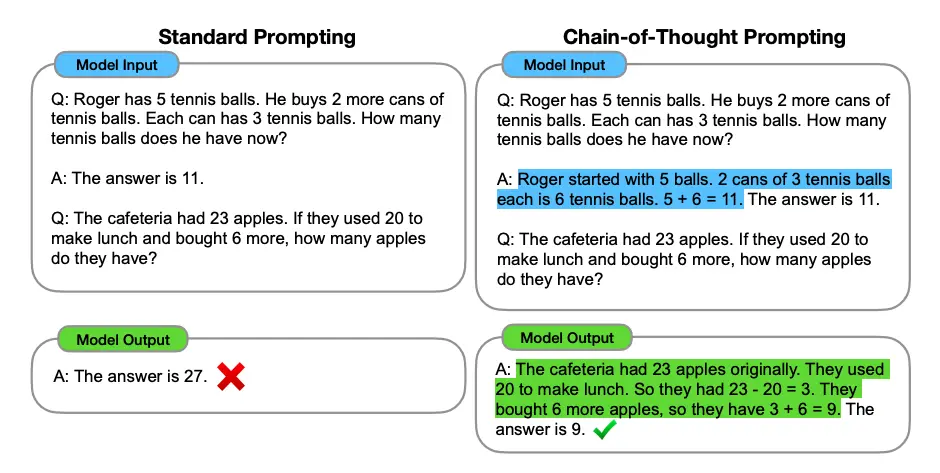

Fonte: Wei et al. (2022)

Em outras palavras, damos ao LLM demonstrações de como pensar um problema (cadeias de inferências), o que desbloqueia sua habilidade de raciocínio. A figura abaixo (Wei et al.) ilustra: com prompting tradicional o modelo tende a ir direto à resposta, mas com CoT ele “fala seus pensamentos” passo a passo, resultando em respostas mais precisas.

Estudos mostram ganhos empíricos significativos: por exemplo, ao aplicar few-shot CoT com um modelo de 540B parâmetros (PaLM), a acurácia em um benchmark de problemas matemáticos GSM8K subiu de ~55% para ~74%.

**ATENÇÃO:** O CoT só tende a funcionar bem em modelos grandes. Modelos menores frequentemente produzem raciocínios ilógicos quando forçados a dar “step-by-step” e podem até piorar a acurácia.

Essa abordagem tem mais uma vantagem, ela é interpretável. Ao pedirmos para o modelo expor seu raciocínio ajuda a entender o porquê aquele exemplo foi categorizado com certa classe.

In [8]:
class ClassificacaoPolaridade2(BaseModel):
    raciocinio: str = Field(description='A explicação passo a passo de como a classificação foi decidida.')
    polaridade: Literal['Positivo', 'Neutro', 'Negativo'] = Field(description='A polaridade final do sentimento.')

parser2 = PydanticOutputParser(pydantic_object=ClassificacaoPolaridade2)
format2 = parser2.get_format_instructions()

In [9]:
cot_template = """Classifique a polaridade do texto abaixo:
Exemplo: "Eu estou feliz hoje."
{{
    "raciocinio": "O autor diz estar feliz, o que é um sentimento positivo. Portanto, eu atribuiria a classe Positivo",
    "polaridade": "Positivo"
}}
Texto:
'''
{text}
'''
"""

cot_prompt = PromptTemplate.from_template(cot_template)

In [10]:
cot_chain = (
    cot_prompt
    | llm_groq
    | parser2
)

cot_chain.invoke("Não gostei da sua atitude.")

ClassificacaoPolaridade2(raciocinio="O autor expressa desaprovação com a frase 'Não gostei', indicando um sentimento negativo. ", polaridade='Negativo')

## 3.1. Zero-Shot CoT


Uma variação interessante dessa abordagem é a ideia de Zero-Shot CoT. Ela foi sugerida por [Kojima et al. (2022)](https://arxiv.org/abs/2205.11916) [4]. A técnica envolve basicamente adicionar “Vamos pensar passo a passo” ao final do prompt original. Por mais simples que pareça, essa técnica resultou em resultados significativos, aumentando a precisão no MultiArith de 17,7% para 78,7% por exemplo.

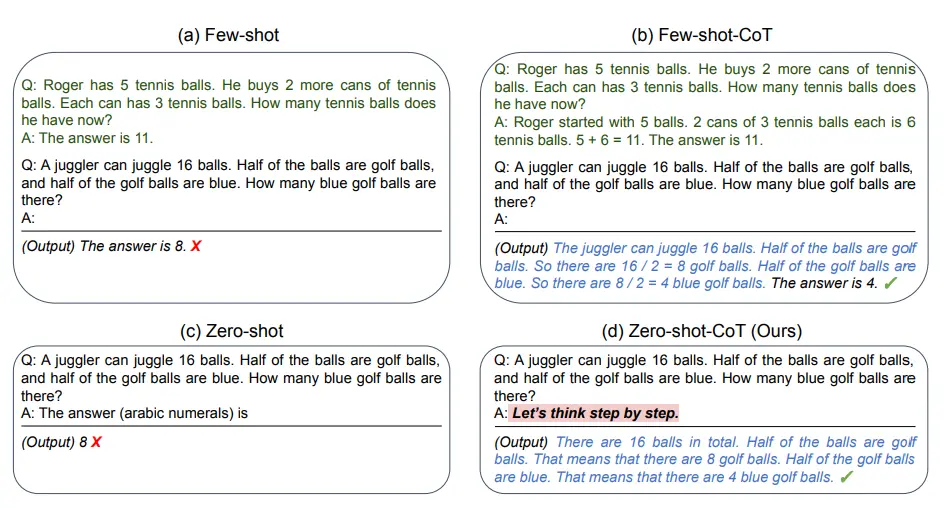

Fonte: Kojima et al. (2022)

In [11]:
zero_cot_template = """Classifique a polaridade do texto abaixo.
Forneça seu raciocínio passo a passo, começando com "Vamos pensar passo a passo.", e depois forneça a polaridade final no formato JSON especificado:
{format_instructions}

Texto:
'''
{text}
'''"""

zero_cot_prompt = PromptTemplate.from_template(
    template=zero_cot_template,
    partial_variables={'format_instructions': format2}
)

In [12]:
from langchain_core.output_parsers import StrOutputParser

zero_cot_chain = (
    zero_cot_prompt
    | llm_groq
    | parser2 # Use parser2 directly as the prompt is designed for it
)

zero_cot_chain.invoke("Não é algo incrível, mas não é ruim também")

ClassificacaoPolaridade2(raciocinio='Vamos pensar passo a passo.\n1. A frase expressa uma opinião moderada, usando expressões como "não é algo incrível" e "não é ruim também".\n2. Não há termos ou expressões que indiquem sentimentos fortes, positivos ou negativos.\n3. O tom geral da frase é neutro, transmitindo uma sensação de indiferença ou falta de entusiasmo.', polaridade='Neutro')

# 4. Atividade Prática: Comparando Técnicas de Prompt

Agora, sua tarefa é aplicar e comparar as técnicas que aprendemos para o nosso problema original: classificação de sentimento em notícias financeiras. Ao final do tutorial, montaremos um comparativo entre os resultados.

**Seu objetivo:** Para cada uma das notícias abaixo, execute as três chains (Zero-Shot, Few-Shot e CoT) e compare os resultados.

Passos:
1. Reutilize o Dataset: Use o dataset de notícias financeiras do Módulo 1.
2. Chain 1 (Zero-Shot): Crie uma chain que classifica uma notícia usando apenas instruções diretas.
3. Chain 2 e 3 (Few-Shot): Crie uma chain que usa 3-4 exemplos de notícias já classificadas para guiar o modelo. Após executar a versão padrão, subistitua os rotulos por valores aleatórios.
4. 4 (CoT): Crie uma chain que instrui o modelo a pensar passo a passo sobre a notícia antes de fornecer a classificação estruturada.
5. Execute e Compare: Percorra uma amostra de notícias do dataset, execute as chains para cada amostra e armazene os resultados.

# Conclusão do Módulo

Neste módulo, passamos de instruções simples para prompts sofisticados. Vimos que:
1. Zero-Shot é um ótimo ponto de partida.
2. Few-Shot melhora a precisão ao fornecer contexto através de exemplos.
3. Chain-of-Thought aprimora o raciocínio do modelo em tarefas complexas.

A engenharia de prompt é um processo iterativo de experimentação. As técnicas que aprendemos aqui são os blocos de construção fundamentais para extrair o máximo de performance de qualquer LLM. No próximo módulo, vamos explorar como combinar as predições de múltiplos modelos através de Ensembles.

# Referências:

[1] Brown, T., Mann, B., Ryder, N., et al. (2020). Language Models are Few-Shot Learners. Advances in Neural Information Processing Systems 33. arXiv:2005.14165

[2] Wei, J., Wang, X., Schuurmans, D., et al. (2022). Chain-of-Thought Prompting Elicits Reasoning in Large Language Models. arXiv:2201.11903

[3] Min, S., Lyu, X., Holtzman, A., et al. (2022). Rethinking the Role of Demonstrations: What Makes In-Context Learning Work?. arXiv:2202.12837

[4] Kojima, T., Gu, S. S., Reid, M., et al. (2022). Large Language Models are Zero-Shot Reasoners. arXiv:2205.11916

[5] Wei, J., Bosma, M., Zhao, V. Y., et al. (2022). Finetuned Language Models Are Zero-Shot Learners. arXiv:2109.01652

- Leitura Adicional:
    - OpenAI Prompt Engineering Best Practices
    - Prompting Guide